In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam

In [11]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSA_features.csv')

In [12]:
df_filtered = df[df['activity'].isin(['sitting', 'jumping'])]

In [13]:
x_data = pd.get_dummies(df_filtered.drop(columns=['activity'])).values.astype('float32')
y_data = df_filtered['activity'].values

In [14]:
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)
train_x_normal = train_x[train_y == 'sitting']

In [15]:
input_dim = train_x_normal.shape[1]
encoding_dim = 14

In [16]:
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [17]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
train_x_normal = scaler.fit_transform(train_x_normal)
test_x = scaler.transform(test_x)

In [18]:
history = autoencoder.fit(train_x_normal, train_x_normal,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_split=0.2)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 1.3021 - val_loss: 1.1035
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 1.2564 - val_loss: 1.0907
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.0909 - val_loss: 1.0723
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3899 - val_loss: 1.0454
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2436 - val_loss: 1.0107
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0512 - val_loss: 0.9710
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1801 - val_loss: 0.9312
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0617 - val_loss: 0.8948
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1093 - val_loss: 0.8645
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.9774 - val_loss: 0.8399
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1011 - val_loss: 0.8211
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9627 - val

In [19]:
reconstructed = autoencoder.predict(test_x)
reconstruction_error = np.mean(np.power(test_x - reconstructed, 2), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [20]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(test_y == 'jumping', reconstruction_error)
optimal_idx = np.argmax(tpr - fpr)
threshold = thresholds[optimal_idx]

In [21]:
predicted_labels = ['jumping' if error > threshold else 'sitting' for error in reconstruction_error]


In [22]:
accuracy = np.mean(np.array(predicted_labels) == test_y)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 99.48%


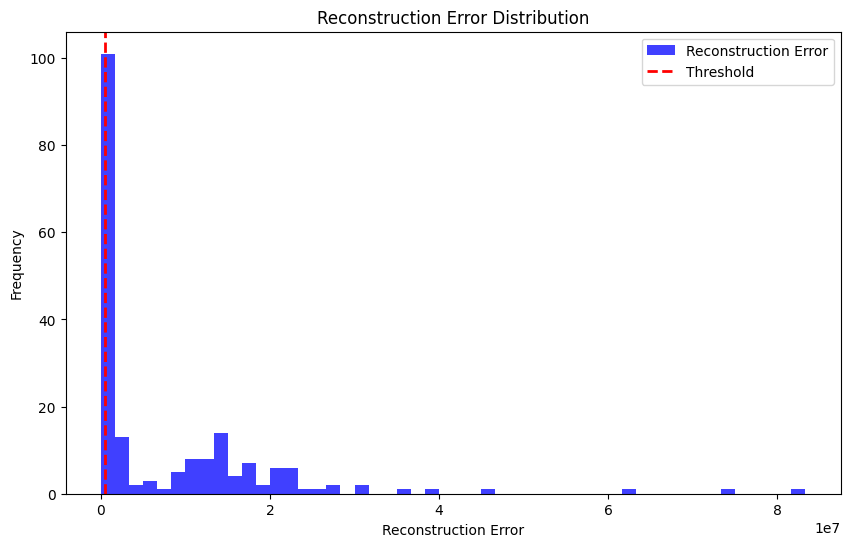

In [23]:
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, alpha=0.75, color='blue', label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', linewidth=2, label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Reconstruction Error Distribution')
plt.legend()
plt.show()